In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [15]:
def run_sort_data(df):
    # Get the list of all textual columns
    text_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Sort the dataframe by the values of all textual columns with sorting priority in the order of column numbers
    df_sorted = df.sort_values(by=text_cols)

    # Print the sorted dataframe
    return(df_sorted)

In [16]:
def run_histogram_columns(df):

    # Select only the numerical columns
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    # Plot each column
    for col in numerical_cols:
        df[col].plot(kind='hist', title=col)
        plt.show()


In [17]:
def run_plot_pairs_of_columns(df):

    # Get a list of all numerical columns in the DataFrame
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Generate all pairs of numerical columns
    num_col_pairs = [(num_cols[i], num_cols[j]) for i in range(len(num_cols)) for j in range(i+1, len(num_cols))]

    # Set up the subplot grid
    num_plots = len(num_col_pairs)
    num_cols = 3 # Number of columns in the grid
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    # Loop through each pair of numerical columns and plot a scatter plot with regression line
    for i, (x_col, y_col) in enumerate(num_col_pairs):
        ax = axes[i]
        ax.scatter(df[x_col], df[y_col])

        # Fit a linear regression model
        model = LinearRegression()
        X = df[x_col].values.reshape(-1, 1)
        y = df[y_col].values.reshape(-1, 1)
        model.fit(X, y)
        y_pred = model.predict(X)

        # Add regression line to the plot
        ax.plot(X, y_pred, color='red')

        # Add legend with equation and R-squared value
        equation = 'y = {:.2f}x + {:.2f}'.format(model.coef_[0][0], model.intercept_[0])
        r_squared = 'R^2 = {:.2f}'.format(model.score(X, y))
        ax.legend([equation, r_squared], loc='upper left')

        # Set plot title and axis labels
        ax.set_title('{} vs. {}'.format(y_col, x_col))
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    # Remove any extra plots from the grid
    for ax in axes[num_plots:]:
        ax.remove()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [18]:
def split_and_compute_statistics(df, split_columns, numerical_columns):
    groups = df.groupby(split_columns)
    statistics = {}
    for group_name, group in groups:
        statistics[group_name] = {}
        for col in numerical_columns:
            statistics[group_name][col + "_mean"] = group[col].mean()
            statistics[group_name][col + "_stddev"] = group[col].std()
    return statistics
def plot_normalized_numerical_columns(df, split_columns, numerical_columns, num_plots=12):
    groups = df.groupby(split_columns)
    group_sizes = groups.size().sort_values(ascending=False)
    top_groups = group_sizes.index[:num_plots]
    fig, ax = plt.subplots(num_plots, 1, figsize=(10,30))
    for i, group_name in enumerate(top_groups):
        group = groups.get_group(group_name)[numerical_columns].values
        img = ax[i].imshow(group, cmap="hot",aspect='auto')
        ax[i].set_title(group_name)
        fig.colorbar(img, ax=ax[i])
        ax[i].set_xticks(range(len(numerical_columns)))
        ax[i].set_xticklabels(numerical_columns)
        ax[i].set_yticks(range(len(group)))
        ax[i].set_yticklabels(groups.get_group(group_name).index.values)
        ax[i].set_xlabel('Column Name')
        ax[i].set_ylabel('Row Numbers')
    plt.tight_layout()
    plt.show()

def run_split_data(df):
    num_col_set = list(df._get_numeric_data().columns)
    num_cols = num_col_set
    df[num_cols]=zscore(df[num_cols])

    cat_col_set = [field for field in df.columns if field not in num_cols]  # Specify categorical columns to split data for Sankey nodes
    cat_cols = cat_col_set

    statistics = split_and_compute_statistics(df, cat_cols, num_cols)
    #print(statistics)
    plot_normalized_numerical_columns(df, cat_cols, num_cols,12)

In [19]:
def run_cluster_data(df):
    # Select the numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns
    df = df.dropna()
    # Standardize the numerical columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Cluster the data using KMeans
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(df[numerical_cols])

    # Plot the boxplots for each cluster and each numerical column
    for col in numerical_cols:
        fig, ax = plt.subplots()
        boxplot_data = [df.loc[clusters == i, col] for i in range(n_clusters)]
        ax.boxplot(boxplot_data, vert=False)
        ax.set_xlabel(col)
        ax.set_yticklabels(['Cluster {}'.format(i+1) for i in range(n_clusters)])
        plt.show()

In [20]:
def run_gpt_command(user_question,df):
    if user_question == 'Split Data by Text Columns and Image Numerical Columns':
        gpt_command = 'Generate Python code to split a tabular dataset by the values of the textual columns \
            and compute statistics (mean and standard deviation) of every split for the numerical columns.\
            Sort the groups by decreasing order of the number of rows. Add a module to produce an array of \
            figures for the top 12 groups, each containing an image representation of the normalized numerical \
            columns using mat show or imshow. For each image, add a title with the group name. \
            Also add x and y axes tick labels with column headers and row numbers on the original data respectively'
        run_split_data(df)
        
    elif user_question == 'Cluster Data by Numerical Columns and Boxplot Clusters':
        gpt_command = 'Generate Python code to cluster numerical tabular data and show the clusters as boxplots'
        run_cluster_data(df)
        
    elif user_question == 'Sort Data by Text Columns':
        gpt_command = 'Generate Python code to sort tabular data by the values of the textual columns with sorting \
        priority in the order of column numbers'
        df_sorted = run_sort_data(df)
        display(df_sorted)
    
    elif user_question == 'Histogram all numerical columns':
        gpt_command = 'Generate Python code to plot all numerical columns of a tabular dataset'
        run_histogram_columns(df)

    elif user_question == 'Plot all pairs of numerical columns':
        gpt_command = 'Generate python code to produce an array of plots of all pairs of numerical columns in a \
        tabular dataset. Include a regression segment for each plot and annotate the plot with a legend containing \
        the equation and R-squared values for each regression'
        run_plot_pairs_of_columns(df)

    return(gpt_command)

In [21]:
# Load the tabular data into a pandas dataframe
df = pd.read_csv('kangae_new.csv')
# df = df.iloc[1:1000,:]
df

,Manufacturer,Product,Application,StorageTime,Price,Cost,StorageCost
0,M2,P8,A4,180.439605,5386.11,4400.0,0.622555
1,M6,P1,A6,11755.868532,346780.51,276000.0,17.163902
2,M6,P1,A8,200.829625,6136.25,5000.0,0.856699
3,M2,P6,A2,626.213303,18977.77,14700.0,2.463429
4,M4,P5,A6,6129.229761,201552.89,160000.0,11.355681
...,...,...,...,...,...,...,...
429,M7,P5,A8,217.348529,6013.79,4900.0,0.412515
430,M2,P2,A8,255.061597,7965.20,6500.0,0.564033
431,M8,P3,A5,738.679112,23800.92,19200.0,1.862329
432,M8,P2,A3,3833.362463,108160.48,86700.0,7.497880


In [22]:
user_question = 'Sort Data by Text Columns'
# user_question = 'Plot all numerical columns'
# user_question = 'Plot all pairs of numerical columns'
# user_question = 'Split Data by Text Columns and Image Numerical Columns'
# user_question = 'Cluster Data by Numerical Columns and Boxplot Clusters'
gpt_command = run_gpt_command(user_question,df)
gpt_command

,Manufacturer,Product,Application,StorageTime,Price,Cost,StorageCost
350,M1,P1,A2,639.501626,20316.00,16200.0,0.905413
100,M1,P1,A3,1264.636376,36924.99,29600.0,3.112455
192,M1,P1,A4,2359.213188,64210.60,51000.0,3.350151
194,M1,P1,A6,1378.808549,38258.19,30400.0,3.466220
247,M1,P1,A7,237.544826,8003.87,6500.0,0.501284
...,...,...,...,...,...,...,...
242,M8,P7,A8,178.369336,4351.59,3500.0,0.374160
30,M8,P8,A3,277.706947,10646.56,8400.0,0.867484
274,M8,P8,A4,1143.566890,37938.01,30400.0,3.369960
43,M8,P8,A5,1384.649214,47046.20,37600.0,3.189083


'Generate Python code to sort tabular data by the values of the textual columns with sorting         priority in the order of column numbers'

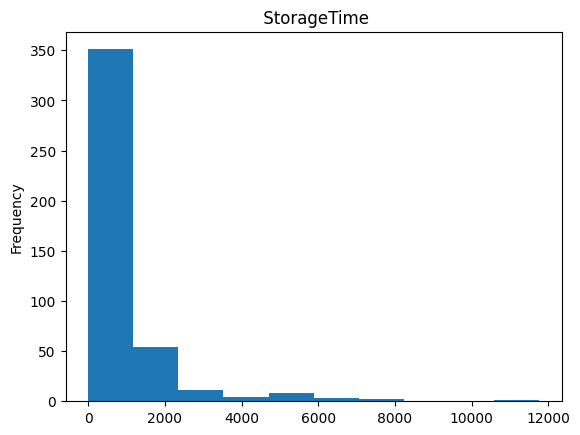

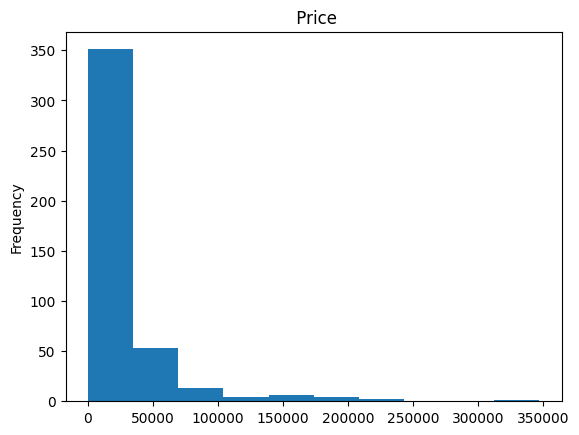

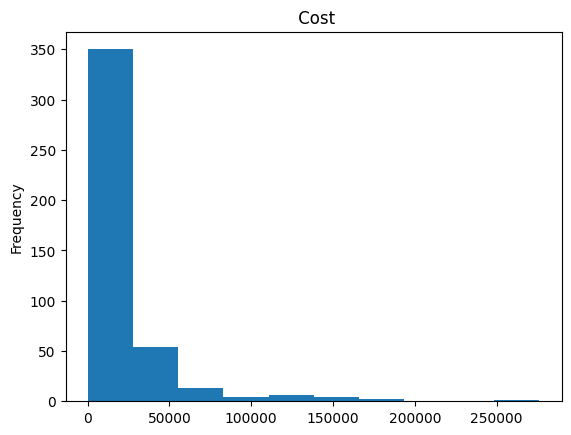

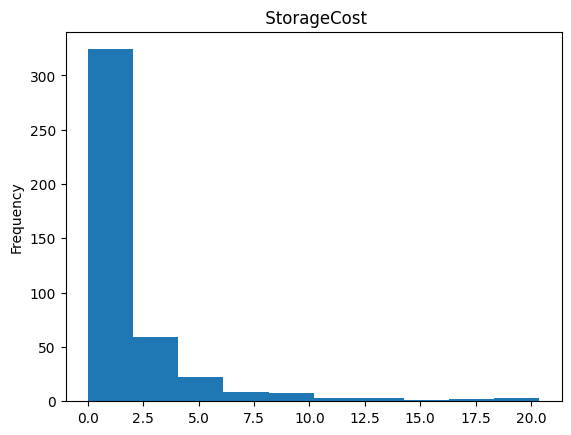

'Generate Python code to plot all numerical columns of a tabular dataset'

In [23]:
user_question = 'Histogram all numerical columns'
gpt_command = run_gpt_command(user_question,df)
gpt_command

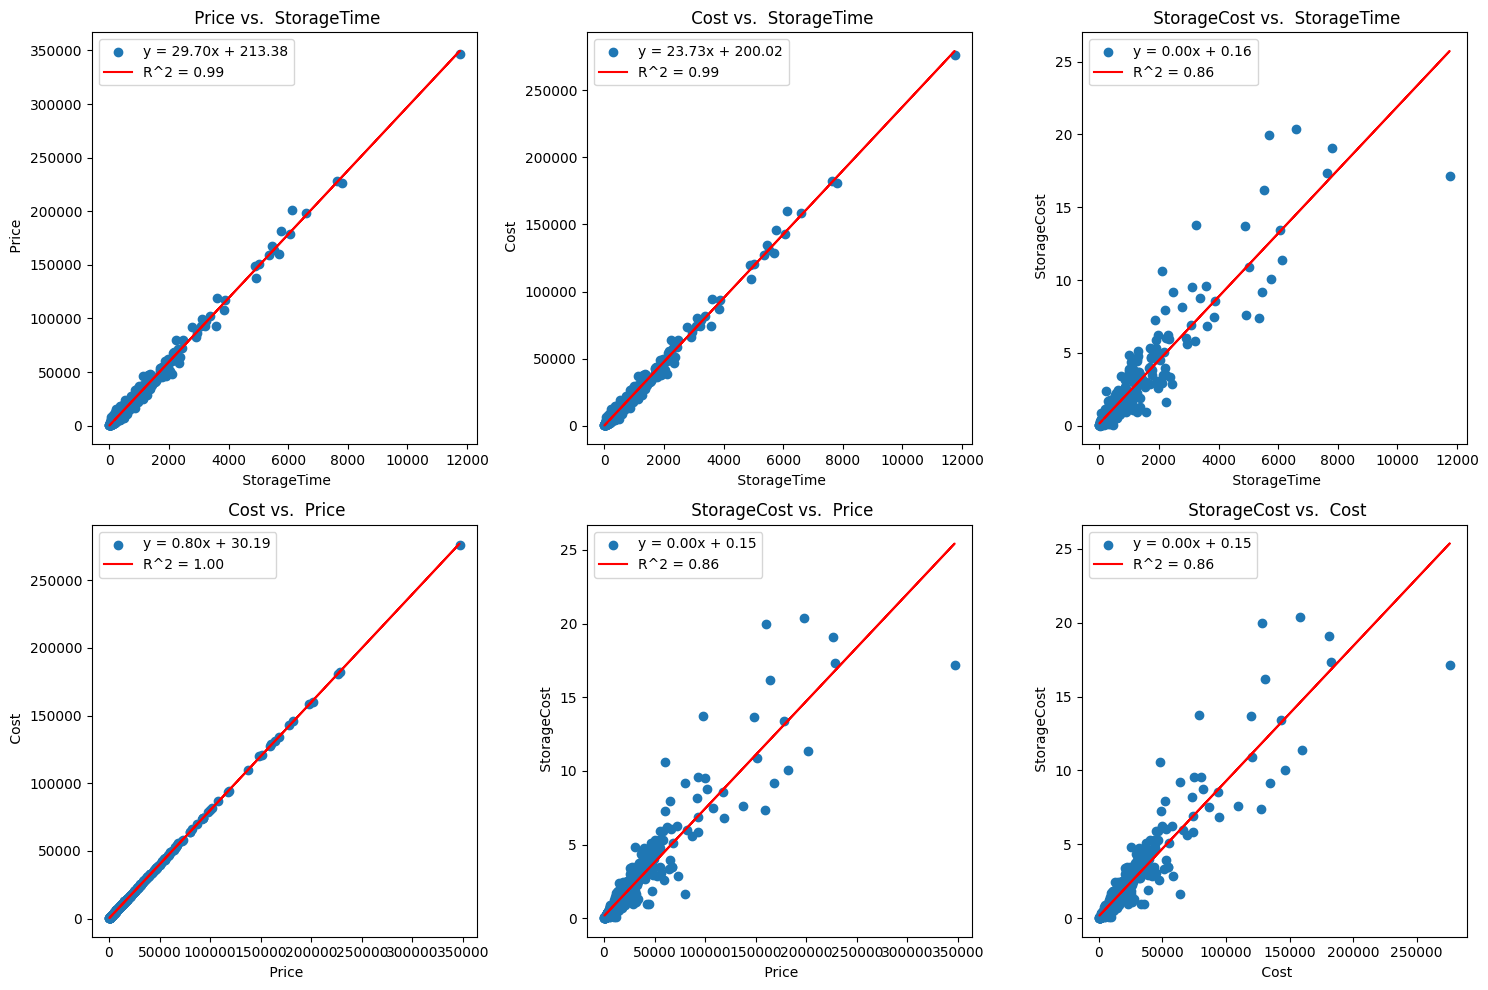

'Generate python code to produce an array of plots of all pairs of numerical columns in a         tabular dataset. Include a regression segment for each plot and annotate the plot with a legend containing         the equation and R-squared values for each regression'

In [24]:
user_question = 'Plot all pairs of numerical columns'
gpt_command = run_gpt_command(user_question,df)
gpt_command

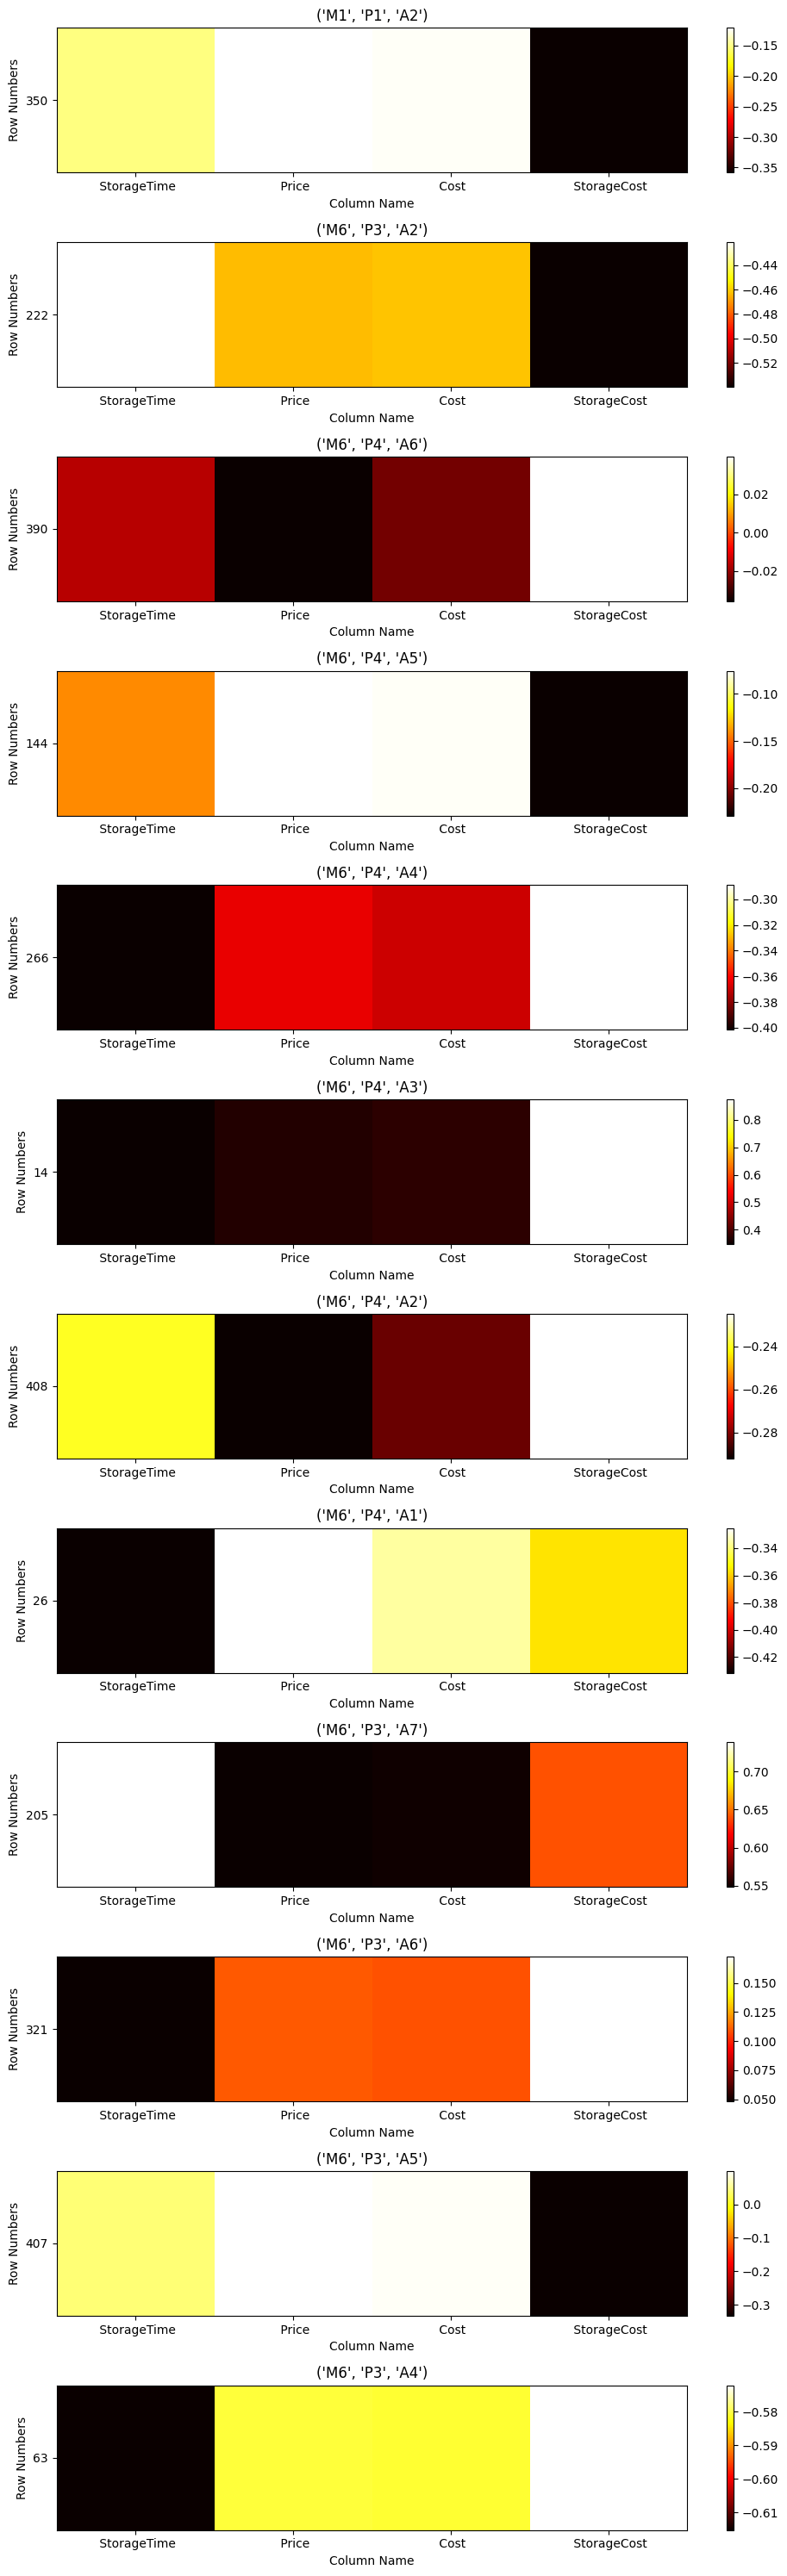

'Generate Python code to split a tabular dataset by the values of the textual columns             and compute statistics (mean and standard deviation) of every split for the numerical columns.            Sort the groups by decreasing order of the number of rows. Add a module to produce an array of             figures for the top 12 groups, each containing an image representation of the normalized numerical             columns using mat show or imshow. For each image, add a title with the group name.             Also add x and y axes tick labels with column headers and row numbers on the original data respectively'

In [25]:
user_question = 'Split Data by Text Columns and Image Numerical Columns'
gpt_command = run_gpt_command(user_question,df)
gpt_command

# 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


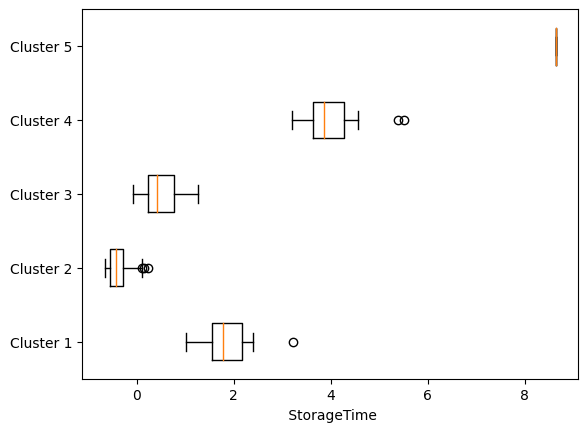

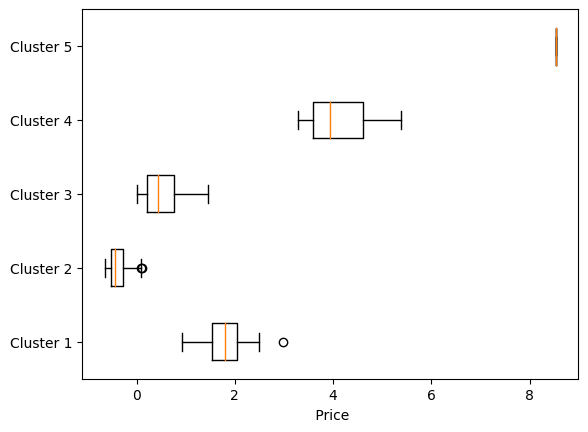

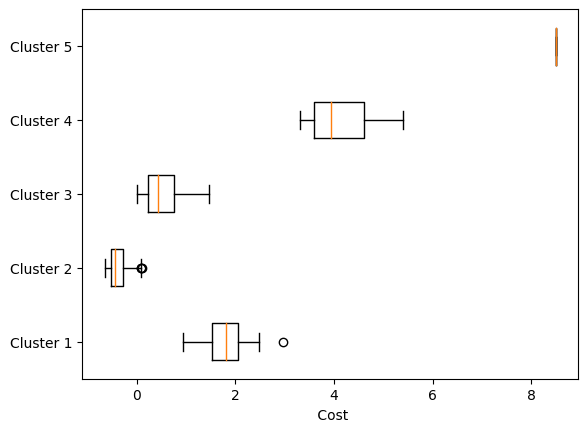

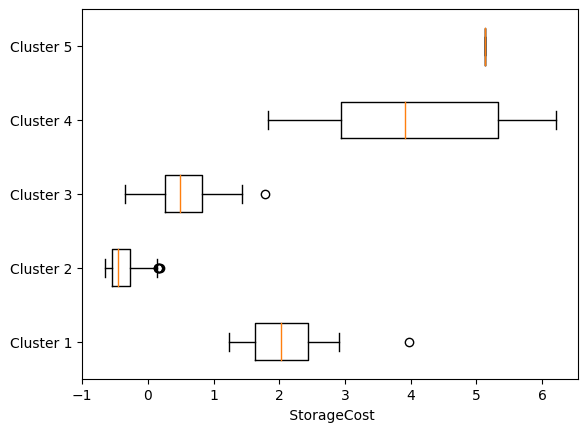

'Generate Python code to cluster numerical tabular data and show the clusters as boxplots'

In [26]:
user_question = 'Cluster Data by Numerical Columns and Boxplot Clusters'
gpt_command = run_gpt_command(user_question,df)
gpt_command